# 03. Machine Learning for music playlists: Preprocessing Data

This is the third post in a series of posts devoted to building music playlists with Scikit-Learn tools.   
This notebook covers steps necessary to preprocess data to use it as input for Scikit-learn machine learning algorithms. 

Previous posts cover the following steps:
* [00_Overview](https://github.com/Tykovka/itunes-music-analysis/blob/master/00_Overview.ipynb) — Overview of the analysis, its goals and methods, installation notes.  
* [01_Data_preparation](https://github.com/Tykovka/itunes-music-analysis/blob/master/01_Data_preparation.ipynb) — Data gathering and cleaning.  
* [02_Data_visualisation](https://github.com/Tykovka/itunes-music-analysis/blob/master/02_Data_Visualisation.ipynb) — Visualisation and overview of data. 

In the previous steps I parsed iTunes music library xml file to create pandas DataFrame (DF) to use as a test dataset. I also transformed the csv file with labelled tracks to a DF to use as a training dataset. Using the Echo Nest API I got 11 music attributes for every song in both sets.

As a result of the above manipulations I have two datasets: 
* training set contains 143 tracks labelled with one of the three classes: "ballet", "cycling", "yoga";
* test dataset contains 536 non-labelled tracks.

#### Contents of the notebook
* [Data transformation to numerical (Numpy) arrays](#Data-transformation-to-numerical-(Numpy)-arrays)
* [Data standardization](#Data-Standardization)
* [Dimensionality reduction](#Dimensionality-reduction)
* [Summary](#Summary)

I start with importing modules required in this notebook.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_context("notebook")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

I store both datasets in HDF5 file format.

In [2]:
store = pd.HDFStore('music_data.h5')

# load train data as DF
train_df = store['train_df']

# load test data as DF
test_df = store['test_df']

## Data transformation to numerical (Numpy) arrays
To work with scikit-learn library, both datasets need to be shaped a bit.
Most machine learning algorithms implemented in scikit-learn expect a numpy array as input. The expected shape of the input is (n_samples, n_features). This applies both to the training and test datasets.
* n_samples: the number of samples; each sample is an item to be classified. In our case this would be a track.
* n_features: the number of features or distinct traits that can be used to describe each item in a quantitative manner. In our case these are the track attributes. Features like "song_title" and "artist" are not quantitative and are not relevant for the classification task, that's why I exclude these from both inputs.

I transform both dataframes to numerical (Numpy) arrays. I copy the original sets and apply the required changes to copies to be able to restore artist and song title later.

### — Training set —
I start with the training set. "category" column in the training set has to be transformed into numerical format to be processed by scikit-learn algorithms as target data (labels). "Typical" machine learning algorithms handle class labels with "no order implied" - unless a ranking classifier (e.g., SVM-rank) is used. Thus, it is safe to use a simple set-item-enumeration to convert the class labels from a string representation into integers.

I use LabelEncoder scikit-learn function, which encodes labels with values between 0 and n_classes-1. 

In [4]:
# transform target classes to numerical labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# list the three categories
categories = list(pd.unique(train_df.category.ravel()))
le.fit(categories)

# list target classes
list(le.classes_)

[u'ballet', u'cycling', u'yoga']

In [5]:
# create an array with target labels
target = le.transform(train_df['category'])
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 1, 0,
       2, 0, 2, 0, 2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2])

I convert the DF to a numerical Numpy array so that each track (observation) forms a row, and the track attributes (features) form columns.

In [6]:
# columns with numerical values
cols = train_df.select_dtypes(exclude=[object]).columns

# convert df to a numerical (Numpy) array
train_data = np.nan_to_num(train_df[cols].values)

# review
train_data.shape

(143, 11)

### — Test set —

In [7]:
# columns with numerical values
cols = test_df.select_dtypes(exclude=[object]).columns

# convert df to a numerical (Numpy) array
test_data = np.nan_to_num(test_df[cols].values)

# review
test_data.shape

(536, 11)

## Data Standardization
It is necessary to perform standardization of features in both sets. This step is required because when training the models, estimators might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. In our case "tempo" attribute varies from 0 to 201.81, whereas "loudness" is in range [-34.53, -1.65], and most features are within [0, 1] boundaries. The estimator will be unable to learn from other features correctly as expected.   

The only family of ML algorithms that is scale-invariant are tree-based methods. For the majority of algorithms, it is essential to rescale the inputs so that their variability reflects their importance, or at least is not in inverse relation to their importance. For lack of better prior information, I standardize each input to the same mean equal to 0 and standard deviation equal to 1. 

I use scikit-learn module StandardScaler for this purpose. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on test data using the transform method.
#### — Training set —

In [8]:
from sklearn import preprocessing

# train the model
std_scale = preprocessing.StandardScaler().fit(train_data)
# perform standardization of features in the training set
train_std = std_scale.transform(train_data)

In [9]:
# print the result of feature standardization
print "Mean, standard deviation, and min/max values after standardization:" 
pd.DataFrame(train_std, 
             columns=cols).describe().loc[['mean', 'std', 'min', 'max'], :]

Mean, standard deviation, and min/max values after standardization:


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
mean,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.26,-2.15,-1.51,-1.00,-1.46,-2.75,-1.11,-0.75,-2.25,-4.17,-1.13
max,1.14,2.73,1.82,1.37,1.74,1.46,0.90,10.62,2.43,1.88,2.24


After standardization, all features have mean equal to 0 and standart deviation equal to 1. The following parameters were used to scale the features.

In [10]:
# make a DF with trained StandardScaler() parameters
params = pd.DataFrame({'mean' : std_scale.mean_, 
                       'std': std_scale.std_}, 
                      index=cols).T

print "StandardScaler parameters: "
params

StandardScaler parameters: 


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.52,0.46,0.45,0.42,5.01,-13.26,0.55,0.05,115.35,3.76,0.35
std,0.41,0.19,0.29,0.42,3.44,7.29,0.50,0.07,30.79,0.66,0.28


#### — Test set —
I use the above parameters to transform non-labelled data, or test data.
It's essential to apply the same parameters and not to retrain the model on the test set. Why? Because I pretend that the test data is "new, unseen data." In a real application, new, unseen data could be 1 data point, or hundreds or thousands of data points. Also the test data is supposed to be from the same distribution as the training data; thus, if both training and test sets are sufficiently large enough, parameters would be the same anyway.

In [11]:
# perform standardization of features of test data
test_std = std_scale.transform(test_data)

In [12]:
# print the result of feature standardization
print "Mean, standard deviation, and min/max values after standardization:" 
pd.DataFrame(test_std, 
             columns=cols).describe().loc[['mean', 'std', 'min', 'max'], :]

Mean, standard deviation, and min/max values after standardization:


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
mean,-0.51,0.64,0.52,-0.29,0.10,0.46,-0.03,0.17,0.04,0.26,0.41
std,0.76,0.95,0.82,0.86,1.04,0.71,1.00,1.03,0.84,0.64,0.93
min,-1.26,-2.16,-1.47,-1.00,-1.46,-2.92,-1.11,-0.43,-3.75,-5.68,-1.15
max,1.14,2.64,1.87,1.36,1.74,1.59,0.90,10.41,2.81,1.88,2.22


#### Plot features: before and after standardization
I plot several features with a scatter plot to illustrate that standardization hasn't affected position of points.

In [13]:
def plot_standard_features(ind1, ind2, labelx, labely):
    """Create two scatterplots with feature values before
    and after standardization.
    """
    fig = plt.figure(figsize=(15,4))
    
    # Add title
    
    fig.text(0.45, 1.05, (labelx + ' & ' + labely),
            size=14)
    
    # Set labels
    
    fig.text(0.3, 0.95, 'Before',
            ha='left', va='center')
    fig.text(0.75, 0.95, 'After',
            ha='right', va='center')
    fig.text(0.5, -0.05, labelx, 
         ha='center', va='center')
    fig.text(0.08, 0.5, labely, ha='center', 
         va='center', rotation='vertical')
    
    # make a scatterplot
    # before standardization
    plt.subplot(121)
    sns.regplot(x=test_data[:,ind1], 
                y=test_data[:,ind2], 
                data=test_data, 
                color='aqua')

    # after standardization
    plt.subplot(122)
    sns.regplot(x=test_std[:,ind1], 
                y=test_std[:,ind2], 
                data=test_std)
    
    # remove the top and right spines from plots
    sns.despine()

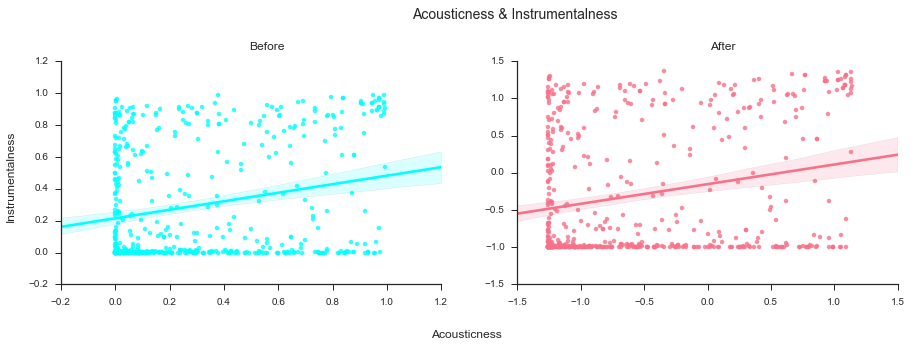

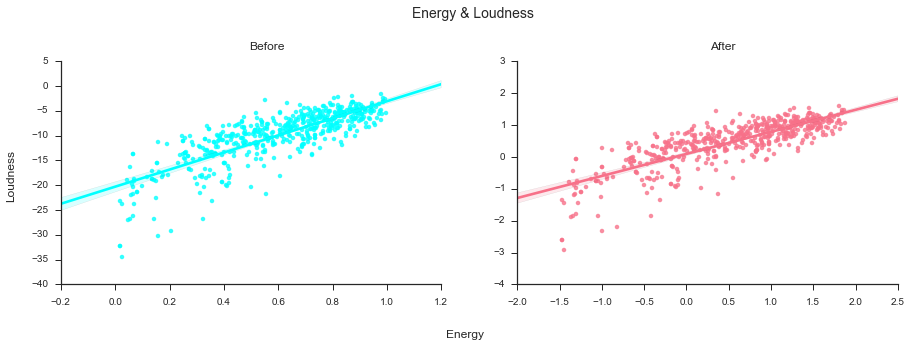

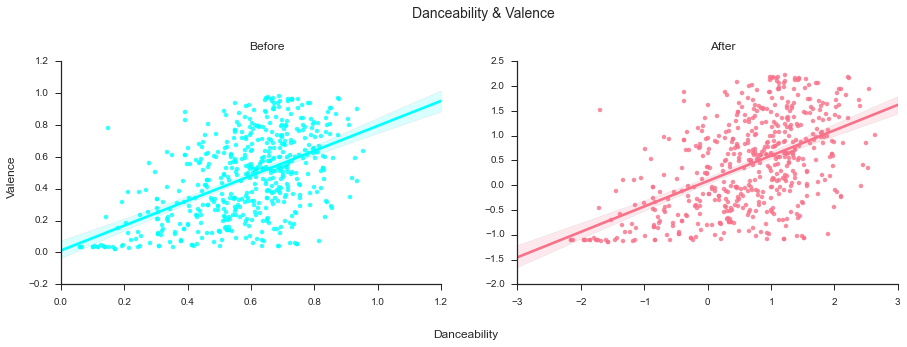

In [14]:
plot_standard_features(0, 3, 'Acousticness', 'Instrumentalness')
plot_standard_features(2, 5, 'Energy', 'Loudness')
plot_standard_features(1, 10, 'Danceability', 'Valence')

Only scale changed after feature standardization.  
## Dimensionality reduction
The significance of feature standardization is seen when performing [Principal Component Analysis (PCA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimensionality. The goal of PCA is to explain the maximum amount of variance with the fewest number of principal components.  
PCA algorithm keeps only the most significant singular vectors to project the data to a lower dimensional space. I perform a PCA on the standardized and non-standardized datasets to transform the dataset onto a 2-dimensional feature subspace. 

In [15]:
from sklearn.decomposition import PCA

# non-standardized data
pca = PCA(n_components=2).fit(train_data)
X_train = pca.transform(train_data)
X_test = pca.transform(test_data)

# standadrized data
pca_std = PCA(n_components=2).fit(train_std)
X_train_std = pca_std.transform(train_std)
X_test_std = pca_std.transform(test_std)

# print the result
print "Training data"
print "Original shape:", train_data.shape
print "Reduced shape:", X_train.shape
print "\nTest data"
print "Original shape:", test_data.shape
print "Reduced shape:", X_test.shape

Training data
Original shape: (143, 11)
Reduced shape: (143, 2)

Test data
Original shape: (536, 11)
Reduced shape: (536, 2)


In [16]:
print "Non-standardized data"
print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            cols)))
    
print "\nStandardized data"
print("Meaning of the 2 components:")
for component in pca_std.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            cols)))

Non-standardized data
Meaning of the 2 components:
-0.005 x acousticness + 0.002 x danceability + 0.004 x energy + -0.004 x instrumentalness + 0.011 x key + 0.107 x loudness + -0.001 x mode + -0.000 x speechiness + 0.994 x tempo + -0.000 x time_signature + 0.003 x valence
0.039 x acousticness + -0.012 x danceability + -0.032 x energy + 0.043 x instrumentalness + 0.071 x key + -0.989 x loudness + -0.006 x mode + -0.001 x speechiness + 0.106 x tempo + -0.025 x time_signature + -0.019 x valence

Standardized data
Meaning of the 2 components:
-0.407 x acousticness + 0.320 x danceability + 0.438 x energy + -0.364 x instrumentalness + -0.016 x key + 0.423 x loudness + 0.018 x mode + 0.089 x speechiness + 0.251 x tempo + 0.151 x time_signature + 0.366 x valence
0.050 x acousticness + 0.138 x danceability + 0.005 x energy + 0.090 x instrumentalness + 0.619 x key + 0.000 x loudness + -0.469 x mode + -0.128 x speechiness + 0.382 x tempo + -0.452 x time_signature + 0.025 x valence


The two components don't actually mean anything physical; they're combinations of all features called "principal components" that are chosen to give the highest number of variation. In the first set of principal components of non-standardized data tempo and loudness have more "weight" for the vector than other features. Whereas in the second set of components almost all features have a "vote". 
### Plot features in 2D
Next, I visualise how the new feature subspace looks like. Class labels are not considered in a PCA but I will add them to the plot for clarity.

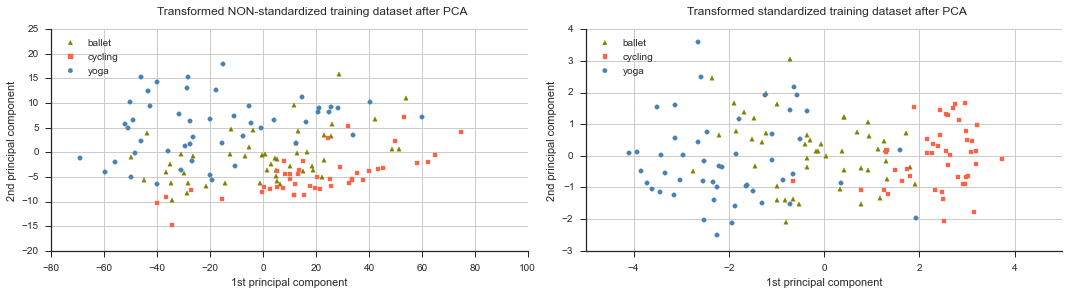

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                               figsize=(15,4))

fig.text(0.15, 1, 
         'Transformed NON-standardized training dataset after PCA',
        ha='left', va='center')
fig.text(0.9, 1, 
         'Transformed standardized training dataset after PCA',
         ha='right', va='center')

for l,c,m in zip(range(0,3), 
                 ('olive', 'tomato', 'steelblue'), 
                 ('^', 's', 'o')):
    ax1.scatter(X_train[target==l, 0], 
                X_train[target==l, 1],
                color=c,
                label=list(le.classes_)[l], # add class labels from the LabelEncoder()
                marker=m
                )

for l,c,m in zip(range(0,3), 
                 ('olive', 'tomato', 'steelblue'), 
                 ('^', 's', 'o')):
    ax2.scatter(X_train_std[target==l, 0], 
                X_train_std[target==l, 1],
                color=c,
                label=list(le.classes_)[l],
                marker=m
                )

for ax in (ax1, ax2):

    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper left')
    ax.grid()

sns.despine()
plt.tight_layout()
plt.show()  

Though points on the two plots are positioned differently, some pattern remains. The yoga class is followed by the ballet class, which is followed by the cycling class.
### Plot data in 3D
The same algorithm can be applied to visualise both datasets in 3D. 

In [18]:
# standadrized data
pca_std_3d = PCA(n_components=3).fit(train_std)
X_train_std_3d = pca_std_3d.transform(train_std)
X_test_std_3d = pca_std_3d.transform(test_std)

# print the result
print "Training data"
print "Original shape:", train_data.shape
print "Reduced shape:", X_train_std_3d.shape
print "\nTest data"
print "Original shape:", test_data.shape
print "Reduced shape:", X_test_std_3d.shape

Training data
Original shape: (143, 11)
Reduced shape: (143, 3)

Test data
Original shape: (536, 11)
Reduced shape: (536, 3)


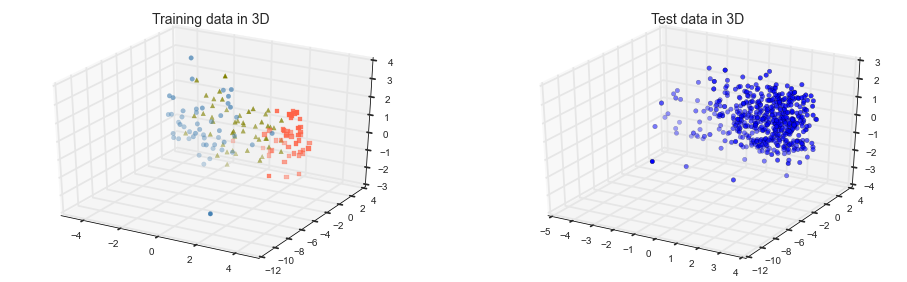

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.3))

# first subplot with training data
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('Training data in 3D', size=14)
for l,c,m in zip(range(0,3), 
             ('olive', 'tomato', 'steelblue'), 
             ('^', 's', 'o')):
    ax.scatter(X_train_std_3d[target==l, 0], 
               X_train_std_3d[target==l, 2],
               X_train_std_3d[target==l, 1],
               zdir='z', s=20,
               depthshade=True,
               color=c,
               label=list(le.classes_)[l], # add class labels from the LabelEncoder()
               marker=m)

# second subplot with test data
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('Test data in 3D', size=14)
ax.scatter(X_test_std_3d[:,0], 
           X_test_std_3d[:,2],
           X_test_std_3d[:,1],
           zdir='z', s=20,
           depthshade=True)

plt.show()

### Save the result
I save target label, standardized data, and 2D data on disc in HDF5 format. Saving numpy array is a bit different process than saving pandas DataFrame. I use **[h5py](https://github.com/h5py/h5py)** library to work with datasets. You can read more about the HDF5 format on [DataJoy](https://www.getdatajoy.com/learn/Read_and_Write_HDF5_from_Python).

In [25]:
import h5py

# open the file 'music_data.h5' in append mode 
with h5py.File('music_data.h5', 'a') as hf:
    hf.create_dataset('train_std', data=train_std)
    hf.create_dataset('test_std', data=test_std)
    hf.create_dataset('train_2d', data=X_train_std)
    hf.create_dataset('test_2d', data=X_test_std)
    hf.create_dataset('target', data=target)
    # review the result
    print hf.items()

[(u'target', <HDF5 dataset "target": shape (143,), type "<i8">), (u'test_2d', <HDF5 dataset "test_2d": shape (536, 2), type "<f8">), (u'test_df', <HDF5 group "/test_df" (8 members)>), (u'test_std', <HDF5 dataset "test_std": shape (536, 11), type "<f8">), (u'test_svm', <HDF5 dataset "test_svm": shape (536, 12), type "<f8">), (u'train_2d', <HDF5 dataset "train_2d": shape (143, 2), type "<f8">), (u'train_df', <HDF5 group "/train_df" (8 members)>), (u'train_std', <HDF5 dataset "train_std": shape (143, 11), type "<f8">)]


## Summary
In this notebook, I preprocessed data to use it as input for Scikit-learn ML algorithms in the following posts. I transformed both dataframes to numerical (Numpy) arrays, performed feature standardization and applied Principal Component Analysis for dimensionality reduction. In the end, I stored the results of these manipulations in HDF5 format.  

In the next post [04_Novelty_detection](https://github.com/Tykovka/itunes-music-analysis/blob/master/04_Novelty_detection.ipynb) I will apply One-Class SVM algorithm to identify tracks in the non-labelled test dataset that fit classes in the training dataset and eliminate tracks that completely unfit the classes.